房屋價格預測 - 多元線性回歸

📊 原始資料形狀:
   訓練集: (1460, 81)
   測試集: (1459, 80)

🗑️  識別要刪除的欄位 (>50% 缺值):
   共 6 個欄位
   ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']

✅ 資料清理完成:
   訓練集: (1460, 75)
   測試集: (1459, 74)

🎯 目標變數: SalePrice
   目標值統計: min=34900.00, max=755000.00, mean=180921.20

🔧 特徵工程:
   數值特徵: 36
   類別特徵: 37
   處理後特徵數: 266

🎯 特徵選擇方法: KBest (f_regression)
   選擇 50 個最重要特徵 (原本 266 個)

📚 訓練/驗證分割:
   訓練集: 1168 樣本
   驗證集: 292 樣本

🚀 訓練多元線性回歸模型...
   ✅ 訓練完成

📊 驗證集評估指標:
   MAE (平均絕對誤差): 20488.18
   RMSE (均方根誤差): 32456.33
   R² (決定係數): 0.8627

🔝 Top 10 特徵係數 (|coef|):
   1. Feature 23: 53272.414987
   2. Feature 33: 31193.849879
   3. Feature 42: 28761.485953
   4. Feature 49: 21289.886252
   5. Feature 24: 18769.896643
   6. Feature 2: 17502.077759
   7. Feature 21: -16202.560412
   8. Feature 28: 15736.450221
   9. Feature 35: 14880.297303
   10. Feature 25: -14086.507054

💾 圖表已保存: predictions_analysis.png

🔮 進行測試集預測...
   測試集預測完成: 1459 個樣本
   預測值範圍: 13058.83 ~ 550003.26



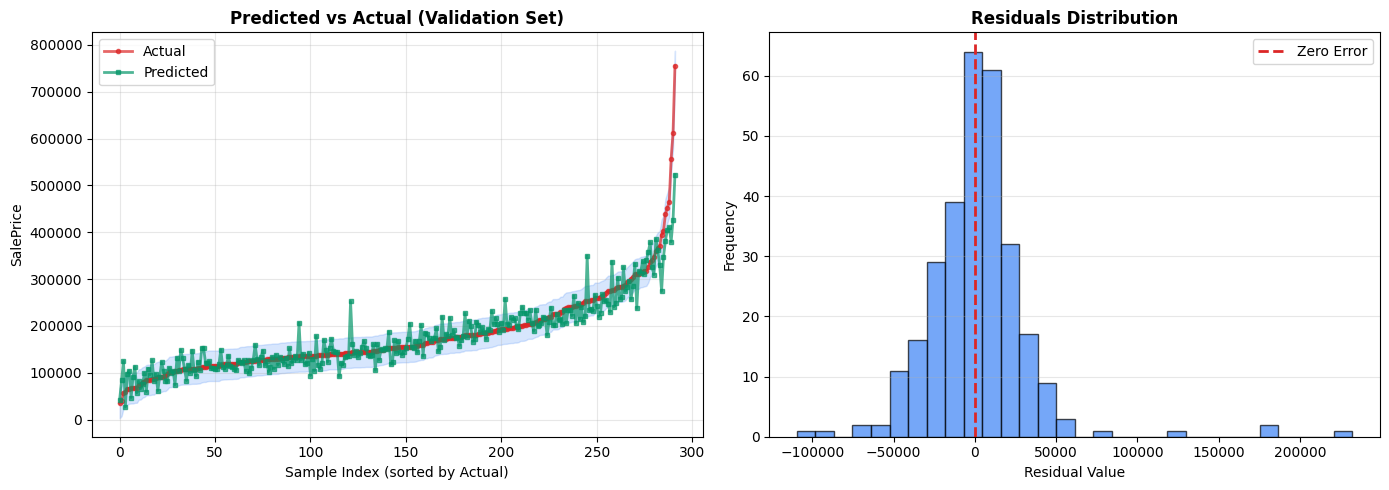

In [20]:
# House Price Prediction - Multiple Linear Regression
# 房屋價格預測 - 多元線性回歸
# Generates submission.csv automatically

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ─────────────────────────────────
# 1. 資料讀取與清理
# ─────────────────────────────────
print("=" * 60)
print("房屋價格預測 - 多元線性回歸")
print("=" * 60)

# 讀取資料
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

print(f"\n📊 原始資料形狀:")
print(f"   訓練集: {train_df.shape}")
print(f"   測試集: {test_df.shape}")

# 儲存測試集 ID
test_ids = test_df['Id'].copy()

def identify_cols_to_drop(train_df, test_df):
    """
    找出訓練集和測試集中超過 50% 缺值的欄位（聯集）
    """
    train_missing_ratio = train_df.isnull().sum() / len(train_df)
    test_missing_ratio = test_df.isnull().sum() / len(test_df)
    
    train_cols_drop = train_missing_ratio[train_missing_ratio > 0.5].index.tolist()
    test_cols_drop = test_missing_ratio[test_missing_ratio > 0.5].index.tolist()
    
    # 聯集：兩個資料集中任一有 >50% 缺值則刪除
    cols_to_drop = list(set(train_cols_drop) | set(test_cols_drop))
    return cols_to_drop

def clean_data(df, cols_to_drop):
    """
    缺值處理：
    - 刪除指定的欄位
    - 其餘欄位：數值填充中位數，類別填充眾數
    """
    df = df.copy()
    
    # 只刪除存在於該資料集的列
    cols_to_drop_actual = [c for c in cols_to_drop if c in df.columns]
    if cols_to_drop_actual:
        df = df.drop(columns=cols_to_drop_actual)
    
    # 填充剩餘缺值
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(df[col]):
                fill_val = df[col].median()
                df[col].fillna(fill_val, inplace=True)
            else:
                mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
                df[col].fillna(mode_val, inplace=True)
    
    return df

# 找出要刪除的欄位（從兩個資料集中統一識別）
cols_to_drop = identify_cols_to_drop(train_df, test_df)

print(f"\n🗑️  識別要刪除的欄位 (>50% 缺值):")
print(f"   共 {len(cols_to_drop)} 個欄位")
if cols_to_drop:
    print(f"   {cols_to_drop}")

# 清理資料（使用相同的欄位列表）
train_df = clean_data(train_df, cols_to_drop)
test_df = clean_data(test_df, cols_to_drop)

print(f"\n✅ 資料清理完成:")
print(f"   訓練集: {train_df.shape}")
print(f"   測試集: {test_df.shape}")

# ─────────────────────────────────
# 2. 特徵與目標分離
# ─────────────────────────────────
TARGET = 'SalePrice'

X_train = train_df.drop(columns=[TARGET, 'Id'])
y_train = train_df[TARGET].astype(float)
X_test = test_df.drop(columns=['Id'])

print(f"\n🎯 目標變數: {TARGET}")
print(f"   目標值統計: min={y_train.min():.2f}, max={y_train.max():.2f}, mean={y_train.mean():.2f}")

# ─────────────────────────────────
# 3. 特徵工程 (One-Hot + Standardization)
# ─────────────────────────────────
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if not pd.api.types.is_numeric_dtype(X_train[c])]

print(f"\n🔧 特徵工程:")
print(f"   數值特徵: {len(num_cols)}")
print(f"   類別特徵: {len(cat_cols)}")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols),
    ],
    remainder="drop",
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"   處理後特徵數: {X_train_processed.shape[1]}")

# ─────────────────────────────────
# 4. 特徵選擇 (KBest)
# ─────────────────────────────────
print(f"\n🎯 特徵選擇方法: KBest (f_regression)")

K = 50  # ← 可調整此值
k_use = max(1, min(K, X_train_processed.shape[1]))

selector = SelectKBest(score_func=f_regression, k=k_use)
X_train_selected = selector.fit_transform(X_train_processed, y_train.values)
X_test_selected = selector.transform(X_test_processed)

print(f"   選擇 {k_use} 個最重要特徵 (原本 {X_train_processed.shape[1]} 個)")

# ─────────────────────────────────
# 5. 訓練測試分割
# ─────────────────────────────────
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_selected, y_train, test_size=0.2, random_state=42
)

print(f"\n📚 訓練/驗證分割:")
print(f"   訓練集: {X_train_split.shape[0]} 樣本")
print(f"   驗證集: {X_val_split.shape[0]} 樣本")

# ─────────────────────────────────
# 6. 模型訓練
# ─────────────────────────────────
print(f"\n🚀 訓練多元線性回歸模型...")

model = LinearRegression()
model.fit(X_train_split, y_train_split)

print(f"   ✅ 訓練完成")

# ─────────────────────────────────
# 7. 模型評估
# ─────────────────────────────────
y_pred_val = model.predict(X_val_split)

mae = mean_absolute_error(y_val_split, y_pred_val)
rmse = mean_squared_error(y_val_split, y_pred_val, squared=False)
r2 = r2_score(y_val_split, y_pred_val)

print(f"\n📊 驗證集評估指標:")
print(f"   MAE (平均絕對誤差): {mae:.2f}")
print(f"   RMSE (均方根誤差): {rmse:.2f}")
print(f"   R² (決定係數): {r2:.4f}")

# ─────────────────────────────────
# 8. 特徵重要性
# ─────────────────────────────────
feature_importance = np.abs(model.coef_)
top_indices = np.argsort(feature_importance)[-10:][::-1]

print(f"\n🔝 Top 10 特徵係數 (|coef|):")
for i, idx in enumerate(top_indices, 1):
    print(f"   {i}. Feature {idx}: {model.coef_[idx]:.6f}")

# ─────────────────────────────────
# 9. 預測與可視化
# ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 預測 vs 實際
ax1 = axes[0]
sorted_idx = np.argsort(y_val_split.values)
ax1.plot(y_val_split.values[sorted_idx], label='Actual', linewidth=2, color='#dc2626', marker='o', markersize=3, alpha=0.7)
ax1.plot(y_pred_val[sorted_idx], label='Predicted', linewidth=2, color='#059669', marker='s', markersize=3, alpha=0.7)
ax1.fill_between(range(len(y_val_split)), y_val_split.values[sorted_idx] - rmse, y_val_split.values[sorted_idx] + rmse, alpha=0.2, color='#3b82f6')
ax1.set_title('Predicted vs Actual (Validation Set)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Sample Index (sorted by Actual)')
ax1.set_ylabel('SalePrice')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 殘差分布
ax2 = axes[1]
residuals = y_val_split.values - y_pred_val
ax2.hist(residuals, bins=30, color='#3b82f6', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='#dc2626', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_title('Residuals Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Residual Value')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
print(f"\n💾 圖表已保存: predictions_analysis.png")

# ─────────────────────────────────
# 10. 測試集預測與生成提交文件
# ─────────────────────────────────
print(f"\n🔮 進行測試集預測...")

y_test_pred = model.predict(X_test_selected)

# 確保預測值非負（房價不能為負）
y_test_pred = np.maximum(y_test_pred, 0)

print(f"   測試集預測完成: {len(y_test_pred)} 個樣本")
print(f"   預測值範圍: {y_test_pred.min():.2f} ~ {y_test_pred.max():.2f}")

# 生成提交文件
submission_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

submission_df.to_csv('submission.csv', index=False)

print(f"\n✅ 提交文件已生成: submission.csv")
print(f"   形狀: {submission_df.shape}")
print(f"\n📋 提交文件預覽 (前 10 行):")
print(submission_df.head(10))

# ─────────────────────────────────
# 11. 最終總結
# ─────────────────────────────────
print(f"\n" + "=" * 60)
print("📈 訓練總結")
print("=" * 60)
print(f"✅ 訓練樣本: {X_train_split.shape[0]}")
print(f"✅ 驗證樣本: {X_val_split.shape[0]}")
print(f"✅ 測試樣本: {X_test_selected.shape[0]}")
print(f"✅ 使用特徵數: {k_use}")
print(f"✅ 驗證 MAE: {mae:.2f}")
print(f"✅ 驗證 RMSE: {rmse:.2f}")
print(f"✅ 驗證 R²: {r2:.4f}")
print(f"✅ 提交文件: submission.csv")
print("=" * 60)

In [23]:
pd.read_csv('./dataset/test.csv').shape, pd.read_csv('./submission.csv').shape

((1459, 80), (1459, 2))